Author : Richard A. Wolf  
Last update : April 2024  
Sources : this notebook was inspired by [Craig Gidney's "getting started" notebook](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb) introducing the [Stim library](https://github.com/quantumlib/Stim)

In [34]:
import pymatching
import stim
import numpy as np
import matplotlib.pyplot as plt

depolarisation_probability = 0.03
flip_probability = 0.1
NB_SHOTS = 100_000


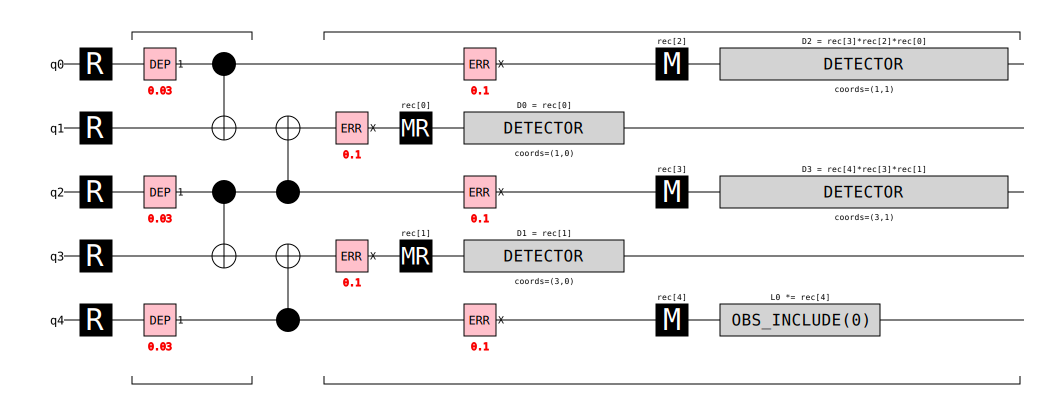

In [35]:
stim_code = stim.Circuit.generated(
              "repetition_code:memory",
              rounds=1,
              distance=3,
              before_round_data_depolarization=depolarisation_probability,
              before_measure_flip_probability=flip_probability
             )
stim_code.diagram('timeline-svg')

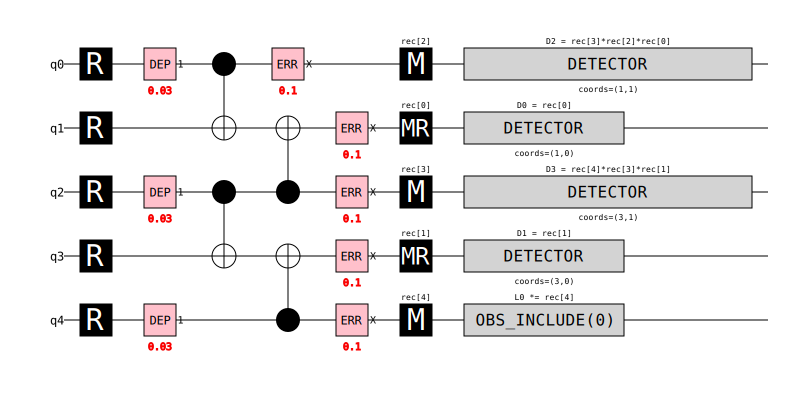

In [36]:
def make_repetition_code(depolarisation_proba:float, flip_proba:float) -> stim.Circuit:
    """Creates a repetition code circuit."""
    code = stim.Circuit()
    nb_qbits = 5

    for qb in range(nb_qbits):
        code.append("R", [qb])
            
    for qb in [0,2,4]:
        code.append_operation("DEPOLARIZE1", qb, depolarisation_proba)

    code.append("CNOT", [0, 1])
    code.append("CNOT", [2, 3])
    code.append("CNOT", [2, 1])
    code.append("CNOT", [4, 3])

    for qb in range(nb_qbits):
        code.append("X_ERROR", qb, flip_proba)

    code.append("MR", [1, 3])
    code.append("M", [0, 2, 4])
    
    code.append("DETECTOR", [stim.target_rec(-5)], [1,0])
    code.append("DETECTOR", [stim.target_rec(-4)], [3,0])
    code.append("DETECTOR", [stim.target_rec(-2), stim.target_rec(-3), stim.target_rec(-5)], [1,1])
    code.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-4)], [3,1])
    
    
    code.append("OBSERVABLE_INCLUDE", [stim.target_rec(-1)], 0)

    return code

our_code = make_repetition_code(depolarisation_proba=depolarisation_probability, flip_proba=flip_probability)
our_code.diagram('timeline-svg')

In [37]:
stim_DEM = stim_code.detector_error_model()
our_DEM = our_code.detector_error_model()
print(our_DEM == stim_DEM)

True


In [38]:
def benchmark_decoder_perf(depolarisation_proba:float=0.0, flip_proba:float=0.0, nb_shots:int=100_000, stim_default:bool=False):

    # Create a circuit
    code_circuit = None
    if stim_default:
        code_circuit = stim_code = stim.Circuit.generated(
              "repetition_code:memory",
              rounds=1,
              distance=3,
              before_round_data_depolarization=depolarisation_proba,
              before_measure_flip_probability=flip_proba
             )
    else:
        code_circuit = make_repetition_code(depolarisation_proba=depolarisation_proba, flip_proba=flip_proba)
    
    # Create a detector sampler
    detector_sampler = code_circuit.compile_detector_sampler()
    detection_events, observable_flips = detector_sampler.sample(nb_shots, separate_observables=True)

    # Generate a detector error model
    detector_error_model = code_circuit.detector_error_model(decompose_errors=True)

    # Create a PyMatching decoder based on the detector error model
    decoder = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Use the decoder
    predictions = decoder.decode_batch(detection_events)

    # Count the number of times the decoder failed
    nb_logical_errors = sum(bool(x) != y for x, y in zip(predictions, observable_flips))

    return (nb_logical_errors[0] / nb_shots) * 100

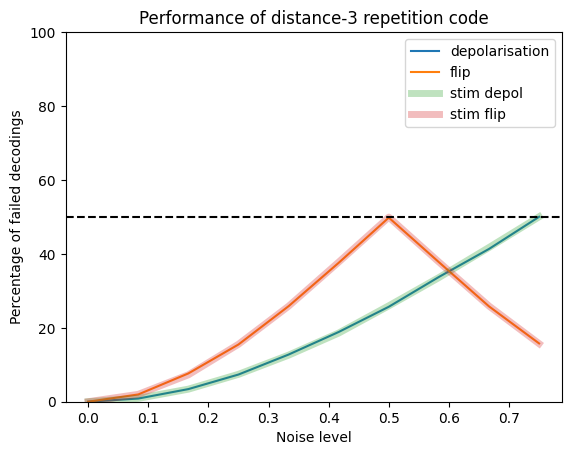

In [33]:
MAX_NOISE_ALLOWED = 3/4

noise_levels = np.linspace(0,MAX_NOISE_ALLOWED,10)

our_decoder_perfs_depolarisation = [benchmark_decoder_perf(depolarisation_proba=p) for p in noise_levels]

our_decoder_perfs_flip = [benchmark_decoder_perf(flip_proba=p) for p in noise_levels]

stim_decoder_perfs_depolarisation = [benchmark_decoder_perf(depolarisation_proba=p, stim_default=True) for p in noise_levels]
stim_decoder_perfs_flip = [benchmark_decoder_perf(flip_proba=p, stim_default=True) for p in noise_levels]


plt.plot(noise_levels, our_decoder_perfs_depolarisation, label="depolarisation")
plt.plot(noise_levels, our_decoder_perfs_flip, label="flip")
plt.plot(noise_levels, stim_decoder_perfs_depolarisation, label="stim depol", linewidth=5, alpha=0.3)
plt.plot(noise_levels, stim_decoder_perfs_flip, label="stim flip", linewidth=5, alpha=0.3)

plt.title("Performance of distance-3 repetition code")
plt.xlabel("Noise level")
plt.ylabel("Percentage of failed decodings")
plt.ylim(0,100)
plt.axhline(y=50, color='black', linestyle='--')


plt.legend()
plt.show()